In [ ]:
# need to get RaceResult 15-16-17
# need to get Workout 0-1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
injury_raw = pd.read_csv('../../hisa-data/injury.csv')
vets_list_raw = pd.read_csv('../../hisa-data/vets_list.csv')
people_raw = pd.read_csv('../../hisa-data/people.csv')
race_result0_raw = pd.read_parquet('../../hisa-data/race_result0.parquet')
#race_result0_raw = race_result0_raw.iloc[0:10000]

In [ ]:
def clean_injury_data(df: pd.DataFrame) -> pd.DataFrame:
    injury = []
    for _, row in df.iterrows():
        try:
            horse_id = row['Horses'].split('HisaHorseId":"')[1].split('"')[0]
        except AttributeError:
            # NULL value
            horse_id = None
        except IndexError:
            # string split error
            horse_id = None

        try:
            responsible_person_id = row['Horses'].split('ResponsiblePersonHisaId":"')[1].split('"')[0]
        except AttributeError:
            # NULL value
            responsible_person_id = None
        except IndexError:
            # string split error
            responsible_person_id = None

        injury.append({
            'date': row['DateOfInjury'],
            'injury_id': row['HisaInjuryId'],
            'horse_id': horse_id,
            'responsible_person_id': responsible_person_id,
            'vets_list_id': row['RelatedVetsListId'],
            'location_id': row['LocationId'],
            'injury_type': row['Type'],
            'circumstances': row['Circumstance'],
            'race_number': row['RaceNumber'],
        })

    return pd.DataFrame(injury)


In [ ]:
def clean_vets_list_data(df: pd.DataFrame) -> pd.DataFrame:
    
    vets_list = df[['VetsListId', 'HisaHorseId', 'CurrentResponsiblePersonId', 'LocationId', 'DatePlacedOnList', 'DateToComeOffList', 'DaysOnList', 'Reason', 'OtherStateReason']]
    vets_list.columns = ['vets_list_id', 'horse_id', 'responsible_person_id', 'location_id', 'date_on_list', 'date_off_list', 'days_on_list', 'reason', 'other_reason']

    return vets_list


In [ ]:
def clean_people_data(df: pd.DataFrame) -> pd.DataFrame:
    
    df['trainer'] = np.where(
        df['Roles'].str.contains('Trainer'),
        1,
        0
    )

    df = df[['HisaPersonId', 'DisplayName', 'trainer']]
    df = df.rename(columns={
        'HisaPersonId': 'person_id',
        'DisplayName': 'name',
        'trainer': 'is_trainer'
    })

    return df

In [ ]:
def clean_race_results_data(df: pd.DataFrame) -> pd.DataFrame:
    columns = {
        'PostPosition': 'post_position',
        'Race_RaceNumber': 'race_number',
        'Horse_Foaled': 'horse_foaled_date',
        'OfficialPosition': 'finish',
        'Race_Date': 'race_date',
        'Horse_HisaId': 'horse_id',
        'Horse_ReferenceNumber': 'horse_reference_number',
        'Horse_Name': 'horse_name', 
        'Race_Condition': 'race_condition',
        'Race_Purse' : 'purse',
        'Race_LocationId' : 'location_id',
        'Race_LocationCode': 'location_code',
        'Race_ClaimingPrice': 'claiming_price',
        'Race_LocationName': 'location_name',
        'Race_Type': 'race_type',
        'Race_DistanceFurlong': 'race_distance',
        'Race_Course': 'surface',
        'Trainer_HisaId': 'trainer_id',
        'Trainer_LastName' : 'trainer_last_name',
        'Trainer_FirstName': 'trainer_first_name',
        'Trainer_ReferenceNumber': 'trainer_reference_number',
        'Scratched': 'scratched_bool',
        'Earnings': 'earnings',
        'Odds': 'odds',
        'Dnf': 'dnf_bool',
        'ProgramNumber': 'program_number'
    }

    df = df[[c for c in columns.keys()]].rename(columns=columns)
    df['scratched'] = np.where(
        df['scratched_bool'],
        1,
        0
    )

    df['dnf'] = np.where(
        df['dnf_bool'],
        1,
        0
    )

    df = df.drop(['scratched_bool', 'dnf_bool'], axis=1)
    df = df.sort_values(by=['horse_reference_number', 'race_date'])

    df = df[df['horse_reference_number'] != 0]

    return df


In [ ]:
injury = clean_injury_data(injury_raw)
injury.head(2)

In [ ]:
vets_list = clean_vets_list_data(vets_list_raw)
vets_list.head(2)

In [ ]:
people = clean_people_data(people_raw)
people.head(2)

In [ ]:
race_results = clean_race_results_data(race_result0_raw)
del race_result0_raw
race_results.head(2)

In [ ]:
race_results.columns

In [ ]:
race_results['age'] = (race_results['race_date'] - race_results['horse_foaled_date']).dt.days
df = race_results.copy()


df['previous_race_date'] = df.groupby('horse_reference_number')['race_date'].shift(1)
df['previous_race_dnf'] = df.groupby('horse_reference_number')['dnf'].shift(1)
df['previous_race_scratch'] = df.groupby('horse_reference_number')['scratched'].shift(1)
df['previous_race_distance'] = df.groupby('horse_reference_number')['race_distance'].shift(1)
df['previous_surface'] = df.groupby('horse_reference_number')['surface'].shift(1)
df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days



df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
df['distance_jump'] = np.where(
    df['distance_delta'] > 2,
    1,
    0
)

df['rest_after_dnf'] = np.where(
    df['previous_race_dnf'] == 1,
    df['days_since_last_race'],
    None
)

df['rest_after_scratch'] = np.where(
    df['previous_race_scratch'] == 1,
    df['days_since_last_race'],
    None
)

df['surface_change'] = np.where(
    df['surface'] != df['previous_surface'],
    1,
    0
)

# maybe should account for covid
df['long_layoff'] = np.where(
    df['days_since_last_race'] > 365,
    1,
    0
)

first_long = df[df['race_distance'] > 8].sort_values(by=['race_date']).groupby(['horse_reference_number', 'trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).first().reset_index()


In [ ]:
df[df['horse_reference_number'] == 10072913][['race_date', 'window_start', 'races_in_last_30_days']]

In [ ]:
trainers = df.groupby(['trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).agg({
    'race_number': 'count',
    'horse_reference_number': 'nunique',
    'scratched': 'sum',
    'dnf': 'sum',
    'age': 'min',
    'days_since_last_race': ['min', 'median'],
    'rest_after_dnf': 'median',
    'rest_after_scratch': 'median',
    'distance_jump': 'sum',
    'surface_change': 'sum',
    'long_layoff': 'sum',
}).reset_index()

trainers.columns = ['trainer_reference_number', 'trainer_last_name', 'trainer_first_name', 
'n_entries', 'unique_horses', 'scratched', 'dnf', 'min_age', 'days_since_last_race_min', 'days_since_last_race_median', 
'rest_after_dnf_median', 'rest_after_scratch_median', 'distance_jumps', 'surface_changes', 'long_layoffs',

]

trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']

trainer_first_long = first_long.groupby(['trainer_reference_number', 'trainer_last_name', 'trainer_first_name']).agg({
    'age': 'median'
}).reset_index().rename(columns={'age': 'first_long_age'})

trainers = trainers.merge(trainer_first_long, on=['trainer_reference_number', 'trainer_last_name', 'trainer_first_name'], how='left')

In [ ]:
trainers.head(2)

In [ ]:
plt.hist(trainers['days_since_last_race_median'], color='blue', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_scratch_median'], color='red', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.hist(trainers['rest_after_dnf_median'], color='black', edgecolor='black', bins=50, alpha=0.5, density=True)
plt.show()

In race results need to do some processing then can aggregate on trainer
- median min age of all trainer's horses
- races last N days
- longer layoffs for distance / surface / condition?
- lost by N+ lengths 
- medications
- travel ?


for an expected model,
- temperature/weather
- sex
- class
- surface
- condtions
- age
- surface fast/slow






In [ ]:
race_results.columns

In [ ]:
injury.head(2)

In [ ]:
injury['circumstances'].value_counts()

# Races RTR

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('../../hisa-data/trainer_uvwxyz.csv')

df.columns

In [ ]:
df['distance'].value_counts()

DISTANCE_LOOKUP = {
    '4 1/2 F': 4.5,
    '5 F': 5,
    '5 1/2 F': 5.5,
    '6 F': 6,
    '6 1/2 F': 6.5,
    '7 F': 7,
    '7 1/2 F': 7.5,
    '1 M': 8,
    '1 M 40 Y': 8.18,
    '1 M 70 Y': 8.32,
    '1 1/16 M': 8.5,
    '1 1/8 M': 9,
    '1 3/16 M': 9.5,
    '1 1/4 M': 10,
    '1 7/16 M': 11.5,
    '1 5/8 M': 13,

}

In [ ]:
df['race_date'] = pd.to_datetime(df['race_date'], format='%Y-%m-%d')
#df['purse'] = df['purse'].str.replace('$', '').str.replace(',', '').astype(float)
df['race_distance'] = df['distance'].map(DISTANCE_LOOKUP)
df['age'] = np.abs(df['age'])


df = df.sort_values(by=['registration_number', 'race_date'])
df['previous_race_date'] = df.groupby('registration_number')['race_date'].shift(1)
df['previous_race_dnf'] = df.groupby('registration_number')['dnf'].shift(1)
df['previous_race_distance'] = df.groupby('registration_number')['race_distance'].shift(1)
df['previous_surface'] = df.groupby('registration_number')['surface'].shift(1)
df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days



df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
df['distance_jump'] = np.where(
    df['distance_delta'] > 2,
    1,
    0
)

df['rest_after_dnf'] = np.where(
    df['previous_race_dnf'] == 1,
    df['days_since_last_race'],
    None
)

df['surface_change'] = np.where(
    df['surface'] != df['previous_surface'],
    1,
    0
)

# maybe should account for covid
df['long_layoff'] = np.where(
    df['days_since_last_race'] > 365,
    1,
    0
)

first_long = df[df['race_distance'] > 8].sort_values(by=['race_date']).groupby(['registration_number', 'trainer_name']).first().reset_index()
first_start = df.drop_duplicates('registration_number').groupby(['trainer_name']).agg({
    'age': 'median',
    'race_distance': 'median',
}).reset_index().rename(columns={
    'age': 'median_first_start_age',
    'race_distance': 'median_first_race_distance'
})


In [ ]:
trainers = df.groupby(['trainer_name']).agg({
    'race_number': 'count',
    'registration_number': 'nunique',
    #'scratched': 'sum',
    'dnf': 'sum',
    'age': 'min',
    'days_since_last_race': ['min', 'median'],
    'rest_after_dnf': 'median',
    #'rest_after_scratch': 'median',
    'distance_jump': 'mean',
    'surface_change': 'mean',
    'long_layoff': 'mean',
}).reset_index()

trainers.columns = ['trainer_name',
'n_entries', 'unique_horses', 'dnf', 'min_age', 'days_since_last_race_min', 'days_since_last_race_median', 
'rest_after_dnf_median', 'distance_jumps', 'surface_changes', 'long_layoffs',

]

#trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']

trainer_first_long = first_long.groupby(['trainer_name']).agg({
    'age': 'median'
}).reset_index().rename(columns={'age': 'first_long_age'})

trainers = trainers.merge(trainer_first_long, on=['trainer_name'], how='left')
trainers = trainers.merge(first_start, on=['trainer_name'], how='left')

In [ ]:
del df
trainers.sort_values('n_entries', ascending=False).head(4)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
trainers = trainers[trainers['n_entries'] > 100]

In [ ]:
X = trainers.set_index('trainer_name')[['min_age',
       'days_since_last_race_min', 'days_since_last_race_median',
       'rest_after_dnf_median', 'distance_jumps', 'surface_changes',
       'long_layoffs', 'first_long_age',
       'median_first_start_age', 'median_first_race_distance']].fillna(0)

y = trainers.set_index('trainer_name')[['dnf_per_entry']].fillna(0)

In [ ]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X,y)

In [ ]:
for col, coef in zip(X.columns, lr.coef_[0]):
    print(f'{col}: {coef}')

In [ ]:
plt.scatter(lr.predict(X), y)

In [ ]:
y.shape

In [ ]:
import boto3
import pandas as pd
import io

In [ ]:
def read_file_from_s3(bucket_name: str, file_name: str, client: boto3.client) -> bytes:
    obj = client.get_object(Bucket=bucket_name, Key=file_name)
    data = obj['Body'].read()
    
    return data

In [ ]:
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

In [ ]:
s3 = boto3.client('s3')
t = read_file_from_s3('hisa-data', 'injury/injury.csv', s3)
df = pd.read_csv(io.BytesIO(t))
df.head(2)

# Baseline

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
races = pd.read_csv('../../hisa-data/races_trainers_a.csv')

In [ ]:
races['sex'].value_counts()

In [ ]:
races['race_surface'] = races['surface'].str.replace('InnerTurf', 'Turf').str.replace('InnerDirt', 'Dirt')

top_conditions = list(races['track_condition'].value_counts().head(7).index)
races['race_condition'] = np.where(
    races['track_condition'].isin(top_conditions),
    races['track_condition'],
    'Other'
)

races = races.rename(columns={'race_type': 'race_type_raw'})
top_types = list(races['race_type_raw'].value_counts().head(6).index)
races['race_type'] = np.where(
    races['race_type_raw'].isin(top_types),
    races['race_type_raw'],
    'Other'
)

races = pd.get_dummies(races, columns=['race_surface', 'race_condition', 'race_type'])

In [ ]:
races.head(2)

In [ ]:
races.columns

In [ ]:
cols_for_model = [
    'age',
       'race_surface_Dirt', 'race_surface_Synthetic', 'race_surface_Turf',
       'race_condition_Fast', 'race_condition_Firm', 'race_condition_Good',
       'race_condition_Muddy', 'race_condition_Other', 'race_condition_Sloppy',
       'race_condition_Wet Fast', 'race_condition_Yielding',
       'race_type_Allowance', 'race_type_Allowance Optional Claimer',
       'race_type_Claiming', 'race_type_Maiden', 'race_type_Maiden Claiming',
       'race_type_Other', 'race_type_Starter Allowance',
       ]

# need to add sex!

In [ ]:
X = races.copy()[cols_for_model]
y = races.copy()['dnf']

In [ ]:
y.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(
    penalty='l2', 
    C = 0.1,
    #class_weight='balanced',
    n_jobs=-1,
    max_iter=10000,
)
lr.fit(X, y)
lr.score(X, y)



In [ ]:
import matplotlib.pyplot as plt


In [ ]:
true_dnf = X[y == 1]
not_dnf = X[y == 0]

plt.hist(lr.predict_proba(true_dnf)[:,1], bins=50, color='red', alpha=0.5, label='DNF', density=True)
plt.hist(lr.predict_proba(not_dnf)[:,1], bins=50, color='blue', alpha=0.5, label='Not DNF', density=True)
plt.legend()

In [ ]:
for col, coef in zip(X.columns, lr.coef_[0]):
    print(f'{col}: {coef}')

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X0, X_valid, y0, y_valid = train_test_split(X, y, test_size=0.2, random_state=524)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.2, random_state=524)

In [ ]:
xgb = XGBClassifier(
    n_jobs=-1,
)

xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)])

print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))
print(xgb.score(X_valid, y_valid))


In [ ]:
true_dnf = X_valid[y_valid == 1]
not_dnf = X_valid[y_valid == 0]

plt.hist(xgb.predict_proba(true_dnf)[:,1], bins=50, color='red', alpha=0.5, label='DNF', density=True)
plt.hist(xgb.predict_proba(not_dnf)[:,1], bins=50, color='blue', alpha=0.5, label='Not DNF', density=True)
plt.legend()

In [ ]:
#X = X.drop(columns='y_pred')
X['y_pred'] = xgb.predict_proba(X)[:,-1]
X.sort_values('y_pred')

# Smoothing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

races = pd.read_csv('../../hisa-data/races_trainers_a.csv')

/Users/jameshull/Documents/GitHub/hisa-trainer-injury/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
races.columns

In [2]:
df = races.groupby('trainer_name').agg({
    'dnf': 'sum',
    'registration_number': 'nunique',
    'ChartID': 'count',
}).reset_index().rename(columns={'registration_number': 'n_horses', 'ChartID': 'n_starts'})

df['dnf_pct'] = df['dnf'] / df['n_starts']

In [3]:
df.head(2)

,trainer_name,dnf,n_horses,n_starts,dnf_pct
0,A. Aceves,0,3,11,0.000000
1,A. Adamo,2,30,110,0.018182


In [4]:
MIN_STARTS = 200

In [5]:
df_threshold = df[df['n_starts'] > MIN_STARTS]

In [6]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import betaln

# Log-likelihood function
def log_likelihood(params, x, total):
    alpha, beta = params
    # Beta-binomial log probability mass function
    log_prob = betaln(x + alpha, total - x + beta) - betaln(alpha, beta) - betaln(x + 1, total - x + 1)
    return -np.sum(log_prob)

# Simulate the career_filtered dataset (replace with actual data)
# career_filtered should be a DataFrame with columns 'H' and 'AB'
import pandas as pd

x = df_threshold['dnf'].values
total = df_threshold['n_starts'].values

# Initial parameters
initial_params = [1, 10]

# Bounds for alpha and beta
bounds = [(0.0001, None), (0.1, None)]

# Minimize the negative log-likelihood
result = minimize(log_likelihood, initial_params, args=(x, total), method='L-BFGS-B', bounds=bounds)

# Extract the coefficients
alpha0, beta0 = result.x

# Print coefficients
print(alpha0, beta0)


2.3757926839940993 118.6404382205047


Alpha: 2.3757926839940993
Beta: 118.6404382205047


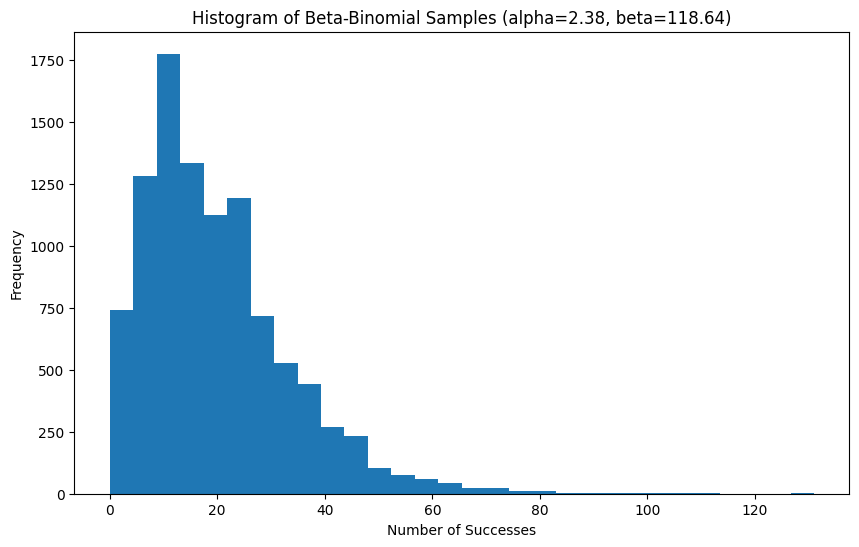

In [7]:
#alpha0 = 101
#beta0 = 288

# Print coefficients
print("Alpha:", alpha0)
print("Beta:", beta0)


# Function to generate beta-binomial samples
def beta_binomial_sample(n, alpha, beta, size):
    # Draw samples from a Beta distribution
    p = np.random.beta(alpha, beta, size)
    # Draw samples from a Binomial distribution
    return np.random.binomial(n, p, size)

# Parameters for generating samples
n_trials = 1000  # Number of trials per sample
n_samples = 10000  # Number of samples to generate

# Generate samples
samples = beta_binomial_sample(n_trials, alpha0, beta0, n_samples)

# Plot the histogram of the samples
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30)
plt.title(f'Histogram of Beta-Binomial Samples (alpha={alpha0:.2f}, beta={beta0:.2f})')
plt.xlabel('Number of Successes')
plt.ylabel('Frequency')
plt.show()

In [8]:
df['dnf_pct_smooth'] = (df['dnf'] + alpha0) / (df['n_starts'] + alpha0 + beta0)

In [9]:
df.head(2)

,trainer_name,dnf,n_horses,n_starts,dnf_pct,dnf_pct_smooth
0,A. Aceves,0,3,11,0.000000,0.017996
1,A. Adamo,2,30,110,0.018182,0.018941


In [10]:
del races

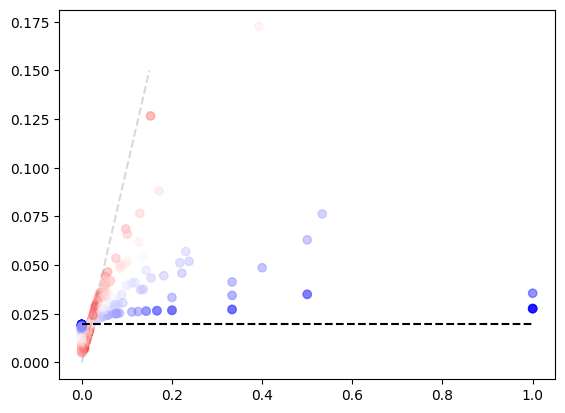

In [29]:
plt.scatter(df['dnf_pct'], df['dnf_pct_smooth'], c=np.log(df['n_starts']), cmap='bwr', alpha=0.5)
plt.plot([0, .15], [0, .15], color='gray', linestyle='--', alpha=0.3)
plt.plot([0, 1], [(alpha0)/(alpha0+beta0), (alpha0)/(alpha0+beta0)], color='black', linestyle='--')
plt.show()

In [31]:
df.head(2)

,trainer_name,dnf,n_horses,n_starts,dnf_pct,dnf_pct_smooth
0,A. Aceves,0,3,11,0.000000,0.017996
1,A. Adamo,2,30,110,0.018182,0.018941


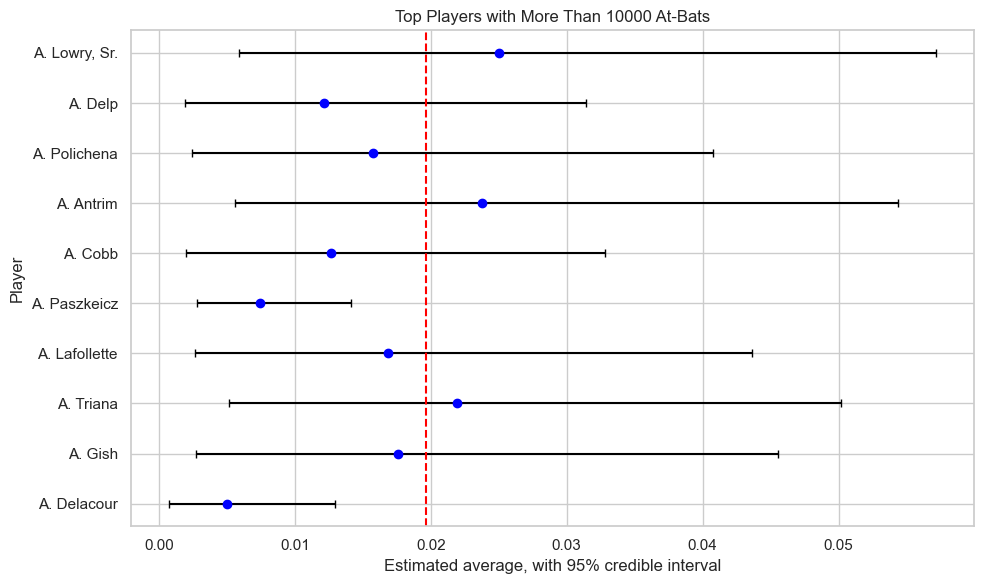

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta



# Calculate the credible intervals
df['low'] = beta.ppf(0.025, alpha0 + df['dnf'], beta0 + df['n_starts'] - df['dnf'])
df['high'] = beta.ppf(0.975, alpha0 + df['dnf'], beta0 + df['n_starts'] - df['dnf'])

# Reorder the players by eb_estimate
df = df.sort_values('dnf_pct_smooth').reset_index(drop=True)
df = df.sample(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with error bars
plt.errorbar(df['dnf_pct_smooth'], df['trainer_name'], 
             xerr=[df['dnf_pct_smooth'] - df['low'], 
                   df['high'] - df['dnf_pct_smooth']], 
             fmt='o', color='blue', ecolor='black', capsize=3)

# Add vertical line for the average
plt.axvline(x=alpha0 / (alpha0 + beta0), color='red', linestyle='--')

# Labels and title
plt.xlabel("Estimated average, with 95% credible interval")
plt.ylabel("Player")
plt.title("Top Players with More Than 10000 At-Bats")

# Show the plot
plt.tight_layout()
plt.show()
